# Simulating a Universe of GRBs
Now we move to the main purpose of the code which is simulating many GRBs from distribution. We will set up a toy model for demonstration. The first thing we need to do is create our population with [popsynth](https://popsynth.readthedocs.io/en/latest/index.html).

In [1]:
# Scientific libraries

import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook
from jupyterthemes import jtplot

jtplot.style(context='notebook', fscale=1, grid=False)
plt.style.use('mike') 

## Create a population of GRBs

Using popsynth, we construct a population. The source parameters to be simulated need to be generated in the population. 


In [3]:
import popsynth
from popsynth.aux_samplers.normal_aux_sampler import NormalAuxSampler
from popsynth.aux_samplers.trunc_normal_aux_sampler import TruncatedNormalAuxSampler
from popsynth.aux_samplers.lognormal_aux_sampler import LogNormalAuxSampler

**cosmogrb** requires certain parameters to be simulated in a population. We will create the auxiliary samplers to do this.


In [4]:
class TDecaySampler(popsynth.AuxiliarySampler):
    def __init__(self):
        """
        samples the decay of the of the pulse 
        """

        super(TDecaySampler, self).__init__(name="tdecay", sigma=None, observed=False)

    def true_sampler(self, size):

        t90 = 10 ** self._secondary_samplers["log_t90"].true_values
        trise = self._secondary_samplers["trise"].true_values

        self._true_values = (
            1.0 / 50.0 * (10 * t90 + trise + np.sqrt(trise) * np.sqrt(20 * t90 + trise))
        )


class DurationSampler(popsynth.AuxiliarySampler):
    def __init__(self):
        "samples how long the pulse last"

        super(DurationSampler, self).__init__(
            name="duration", sigma=None, observed=False
        )

    def true_sampler(self, size):

        t90 = 10 ** self._secondary_samplers["log_t90"].true_values

        self._true_values = 1.5 * t90

Now that we have creates our extra distribution samplers, we can go ahead and create the population sampler. We will use a simple SFR like redshift distribution and a Pareto (power law) luminosity function

In [5]:
# redshift distribution 
r0_true = 3
rise_true = 1.
decay_true = 4.0
peak_true = 1.5

# the luminosity
Lmin_true = 1e51
alpha_true = 1.5
r_max = 7.0


pop_gen = popsynth.populations.ParetoSFRPopulation(
    r0=r0_true,
    rise=rise_true,
    decay=decay_true,
    peak=peak_true,
    Lmin=Lmin_true,
    alpha=alpha_true,
    r_max=r_max,
)

Now set up and add all the auxiliary samplers

In [6]:
ep = LogNormalAuxSampler(mu=300.0, tau=0.5, name="log_ep", observed=False)
alpha = TruncatedNormalAuxSampler(
    lower=-1.5, upper=0.1, mu=-1, tau=0.25, name="alpha", observed=False
)
tau = TruncatedNormalAuxSampler(
    lower=1.5, upper=2.5, mu=2, tau=0.25, name="tau", observed=False
)
trise = TruncatedNormalAuxSampler(
    lower=0.01, upper=5.0, mu=1, tau=1.0, name="trise", observed=False
)
t90 = LogNormalAuxSampler(mu=10, tau=0.25, name="log_t90", observed=False)

tdecay = TDecaySampler()
duration = DurationSampler()
tdecay.set_secondary_sampler(t90)
tdecay.set_secondary_sampler(trise)

duration.set_secondary_sampler(t90)


pop_gen.add_observed_quantity(ep)
pop_gen.add_observed_quantity(tau)
pop_gen.add_observed_quantity(alpha)
pop_gen.add_observed_quantity(tdecay)
pop_gen.add_observed_quantity(duration)

registering auxilary sampler: log_ep
registering auxilary sampler: tau
registering auxilary sampler: alpha
registering auxilary sampler: tdecay
registering auxilary sampler: duration


We sample the population. It is important to specify that there is no selection as we will implement the full trigger later.

In [7]:
pop = pop_gen.draw_survey(no_selection=True, boundary=1e-2)

The volume integral is 114.333557



Expecting 104 total objects
Sampling: log_ep
Sampling: tau
Sampling: alpha
Sampling: tdecay
tdecay is sampling its secondary quantities
Sampling: log_t90
Sampling: trise
Sampling: duration
duration is sampling its secondary quantities
Applying soft boundary



No Selection! Added back all objects
NO HIDDEN OBJECTS
Deteced 104 objects or to a distance of 4.29


In [8]:
pop.display_obs_fluxes_sphere(size=1., cmap='cividis', background_color='black');

We save the population to a file for reloading later

In [8]:
pop.writeto("population.h5")

## Simulation the population with cosmogrb

We will use dask to handle the parallel generation of all the GRBs in the universe. The code can be run serially as well, but it is possible that the time will be equaivalent to the actual age of the Universe. 


In [10]:
from dask.distributed import LocalCluster, Client
from cosmogrb.instruments.gbm import GBM_CPL_Universe

In [11]:
cluster = LocalCluster(n_workers=24)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:45077 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 24 Cores: 96 Memory: 201.45 GB


Now we pass the population file to a specialized GBM observed universe. Here GRBs have simple FRED-like pulses and evolving peak $\nu F_{\nu}$ energies. We need to specify as path to save all the generated files. 

In [11]:
universe = GBM_CPL_Universe('population.h5', save_path="/data/jburgess/cosmogrb/")

Pass the client to the **go** function and wait while your GRBs go off and have their data recorded by GBM... or whatever instrument is included in the package next.

In [12]:
universe.go(client)

When we are done, we will want to save the meta information (file locations, etc) to a file to recover later. We call this object a **Survey**.

In [ ]:
.. note::
   In the future, there will be the option to place the entire simulation in one large file to avoid having to keep track of file locations. For now, if once changes the location of the files, further processing of the survey will not be possible

In [17]:
universe.save('survey.h5')

In [12]:
client.close()
cluster.close()

We can now shut off our cluster.

## Processing a Survey
Creating GRBs does not automatically run an instrument's detection algorithm on them as we want to store the raw data and possibly analyze *why* a GRB was not detected as a function of its latent parameters. This is typically an expensive process, so we will again use dask to farm out jobs. 


In [13]:
cluster = LocalCluster(n_workers=24)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:37589 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 24 Cores: 96 Memory: 201.45 GB


We must import the trigger analysis class specific to GBM for the survey.  An error will occur if we use the wring class.

In [3]:
from glob import glob
from cosmogrb.universe.survey import Survey
from cosmogrb.instruments.gbm.gbm_trigger import GBMTrigger

You do not have threeML installed


/home/jburgess/.venv/cosmogrb/lib/python3.6/site-packages/popsynth-0.3.3-py3.6.egg/popsynth/distribution.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm as progress_bar


The survey can be reloaded from the file we saved. All the information about the GRBs which were simulated is contained in the file. We then process the triggers. We selected a trigger threshold of 4.5 $\sigma$ to mimic the true GBM trigger. Afterwards, we will save the survey back to a file, this time with the processed trigger information.

In [6]:
survey = Survey.from_file('survey.h5')
survey.process(GBMTrigger, client=client, threshold=4.5)
survey.write('survey.h5')

Upon reloading the survey, we can verify that, indeed, GBM triggered on some of the event!

In [4]:
survey = Survey.from_file('survey.h5')
survey.info()

,0
n_grbs,104
is_processed,True
n_detected,62


We can can examine one of the detected GRBs

In [18]:
survey['SynthGRB_1'].detector_info.info()

,0
name,SynthGRB_1
is_detected,True


,0
triggered_detectors,"[b'n2', b'n5']"
triggered_time_scales,"[0.016, 0.016]"
triggered_times,"[3.339550858072471e-11, 3.339550858072471e-11]"


<IPython.core.display.Javascript object>


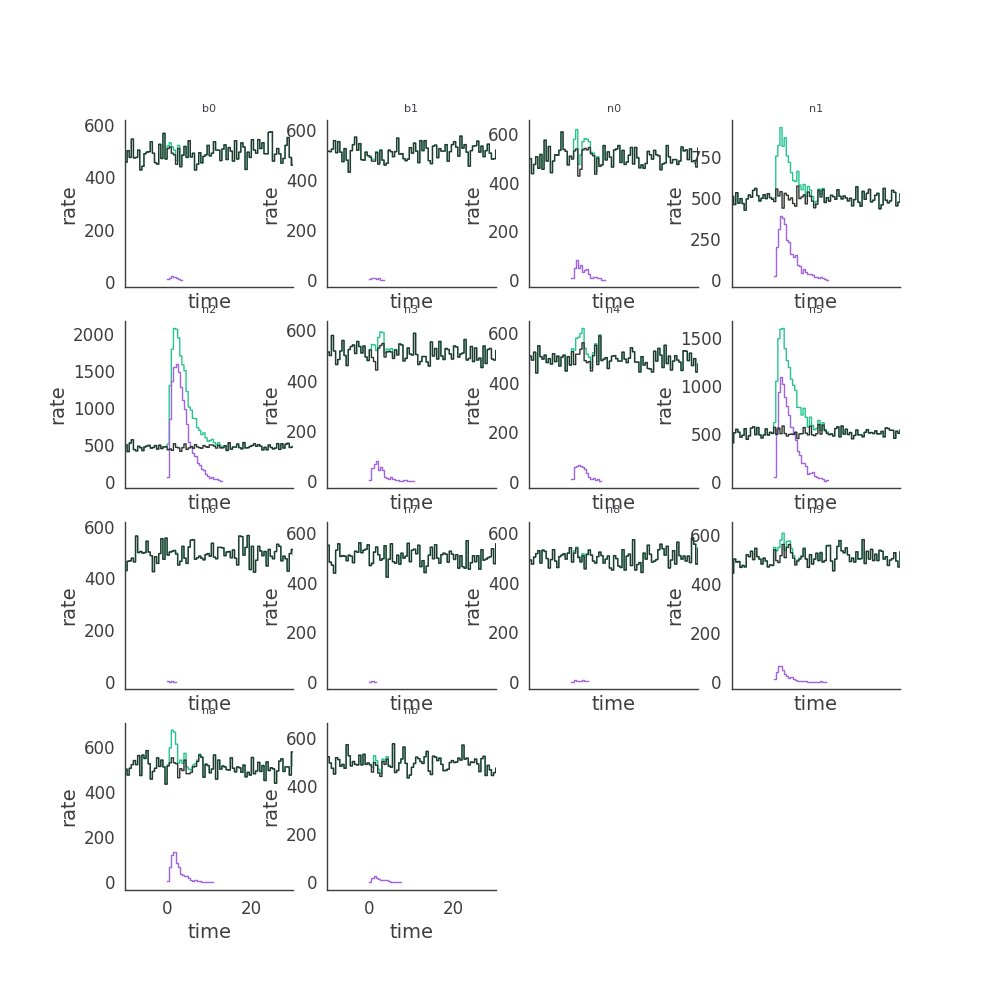

In [20]:
fig, axes = plt.subplots(4,4,sharex=True,sharey=False,figsize=(10,10))
row=0
col = 0
for k,v  in survey['SynthGRB_1'].grb.items():
    ax = axes[row][col]
    
    lightcurve =v['lightcurve']
    
    lightcurve.display_lightcurve(dt=.5, ax=ax,lw=1,color='#25C68C')
    lightcurve.display_source(dt=.5,ax=ax,lw=1,color="#A363DE")
    lightcurve.display_background(dt=.5,ax=ax,lw=1, color="#2C342E")
    ax.set_xlim(-10, 30)
    ax.set_title(k,size=8)
    
    
    
    if col < 3:
        col+=1
    else:
        row+=1
        col=0

axes[3,2].set_visible(False)  
axes[3,3].set_visible(False)      

as well as examining one that was not detected:

In [21]:
survey['SynthGRB_0'].detector_info.info()

,0
name,SynthGRB_0
is_detected,False


,0
triggered_detectors,"[b'na', b'n7', b'n6']"
triggered_time_scales,"[0.016, 0.016, 0.016]"
triggered_times,"[164.20800000008825, 170.0800000000902, 3.4400..."


<IPython.core.display.Javascript object>


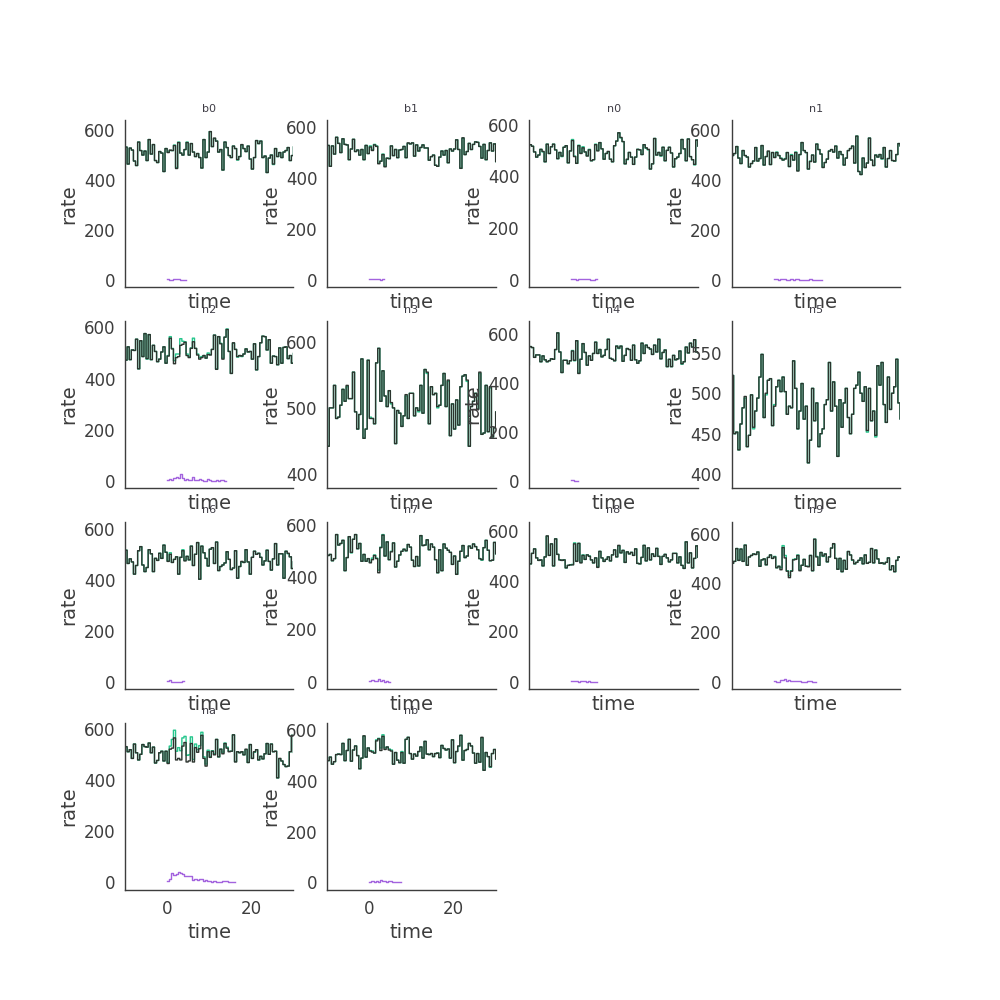

In [22]:
fig, axes = plt.subplots(4,4,sharex=True,sharey=False,figsize=(10,10))
row=0
col = 0
for k,v  in survey['SynthGRB_0'].grb.items():
    ax = axes[row][col]
    
    lightcurve =v['lightcurve']
    
    lightcurve.display_lightcurve(dt=.5, ax=ax,lw=1,color='#25C68C')
    lightcurve.display_source(dt=.5,ax=ax,lw=1,color="#A363DE")
    lightcurve.display_background(dt=.5,ax=ax,lw=1, color="#2C342E")
    ax.set_xlim(-10, 30)
    ax.set_title(k,size=8)
    
    
    
    if col < 3:
        col+=1
    else:
        row+=1
        col=0

axes[3,2].set_visible(False)  
axes[3,3].set_visible(False)      